In this notebook, we fit a 3D feature grid to a set of images comprising renders of the PyTorch3D's cow mesh.

In [1]:
import os
import cv2
import math
import time
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

from typing import Tuple
from itertools import cycle

import pytorch3d.io
import pytorch3d.renderer

from lightplane import Rays, LightplaneRenderer
from utils.dataloader.pt3d_cow_dataset import Pytorch3DCowDataset
from utils.util.camera_util import get_rays_for_extrinsic
from utils.util.grid_util import init_3d_representation
from utils.util.renderer_util import get_predicton_for_view
from utils.util.io_util import save_image_list_to_video
from utils.util.camera_util import get_sphere_cameras

## 1. Data
We first construct a dataset of Pytorch3D's cow, randomly renderered from different views.


In [3]:
seed = 0
image_size = 128
batch_size = 4 # batch size of images we will render and compute loss on. 
device = torch.device("cuda:0")


torch.manual_seed(seed)
dataset = Pytorch3DCowDataset(
    image_size=image_size,
    num_angles=64,
    num_elevations=5,
    device=device,
)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)

(-0.5, 127.5, 127.5, -0.5)

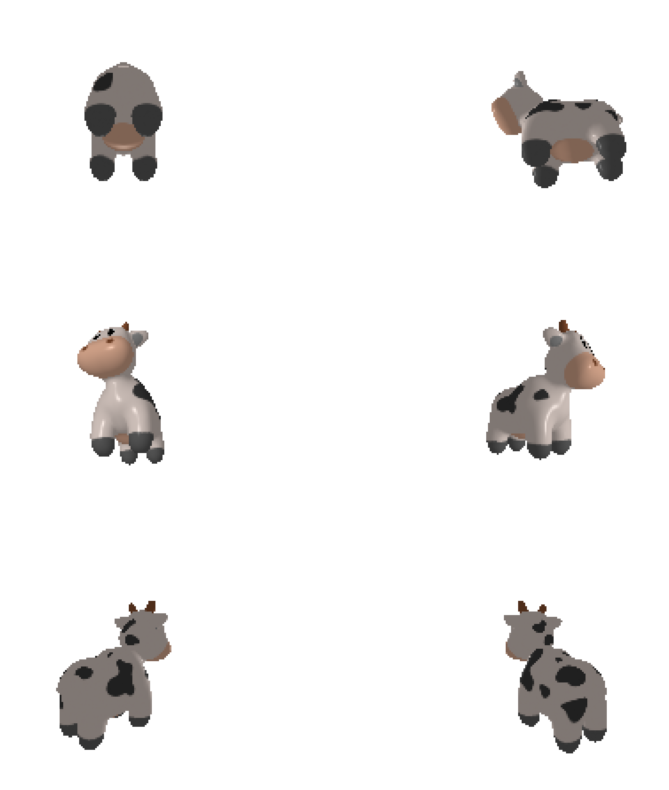

In [4]:
# Visualize 
plt.figure(figsize = (10,10))
plt.subplot(3, 2, 1)
plt.imshow(dataset[0]['images'].clamp(0.0, 1.0))
plt.axis('off')
plt.subplot(3, 2, 2)
plt.imshow(dataset[50]['images'].clamp(0.0, 1.0))
plt.axis('off')
plt.subplot(3, 2, 3)
plt.imshow(dataset[100]['images'].clamp(0.0, 1.0))
plt.axis('off')
plt.subplot(3, 2, 4)
plt.imshow(dataset[150]['images'].clamp(0.0, 1.0))
plt.axis('off')
plt.subplot(3, 2, 5)
plt.imshow(dataset[200]['images'].clamp(0.0, 1.0))
plt.axis('off')
plt.subplot(3, 2, 6)
plt.imshow(dataset[250]['images'].clamp(0.0, 1.0))
plt.axis('off')


## 2. Neural Field Representation

Lightplane uses hybrid representation for neural 3D fields: sampling points' features are calcualted by combining 3D hash grid (currently we support voxel grid and TriPlanes, and will supoort more) and MLPs (`mlp_n_layers_opacity`, `mlp_n_layers_trunk`, `mlp_n_layers_color`); pixel features are rendered by volumetric rendering. 


In [5]:
num_grid_channels = 32
grid = init_3d_representation(
    representation_type="triplane",          # "triplane" or "voxel_grid"
    grid_resolution=64,                      # grid resolution
    num_grid_channels=num_grid_channels,     # grid feature dimension
    device=device,
)

render_module = LightplaneRenderer(
    num_samples=192,                         # sample numbers per ray
    mlp_n_layers_opacity=1,         
    mlp_n_layers_trunk=2,
    mlp_n_layers_color=1,
    color_chn=3,                             # rendered feature dimension
    grid_chn=num_grid_channels,
    mlp_hidden_chn=32,
    opacity_init_bias=-5.0,
    ray_embedding_num_harmonics=2,
    bg_color=1.0,
    mask_out_of_bounds_samples=True,
    inject_noise_sigma=1.0,
).to(device)

optimizer = torch.optim.Adam(
    [
        {"params": grid, "lr": 0.02},
        {"params": render_module.parameters(), "lr": 0.002},
    ],
    lr=0.002,
)

/home/ancao/src/turbo/mambaforge/envs/pytorch2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Optimization

We optimize the neural 3D fields by computing loss on rendered images and ground-truth images.
Thanks to Lightplane's memory efficiency, we can render and calculate on a batch of full images. 

/home/ancao/src/turbo/mambaforge/envs/pytorch2/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Changes in the template code detected -> regenerating triton code.
Generating triton code for `renderer_mlp_util.py`, generation parameters:
    N_LAYERS_TRUNK=2
    N_LAYERS_OPACITY=1
    N_LAYERS_COLOR=1

Generated /nfs/turbo/justincj-turbo/ancao/repos/lightplane/lightplane/triton_src/generated/renderer_mlp_util_t2_o1_c1.py
Changes in the template code detected -> regenerating triton code.
Generating triton code for `renderer_fw.py`, generation parameters:
    N_LAYERS_TRUNK=2
    N_

         0: loss:              0.11188, sec/it: 16.1276.
       100: loss:              0.00677, sec/it: 0.3861.
       200: loss:              0.00405, sec/it: 0.3068.
       300: loss:              0.00234, sec/it: 0.2802.
       400: loss:              0.00132, sec/it: 0.2667.
       500: loss:              0.00096, sec/it: 0.2586.
       600: loss:              0.00079, sec/it: 0.2532.
       700: loss:              0.00068, sec/it: 0.2494.
       800: loss:              0.00063, sec/it: 0.2465.
       900: loss:              0.00058, sec/it: 0.2443.
       999: loss:              0.00055, sec/it: 0.2425.


<Figure size 640x480 with 0 Axes>

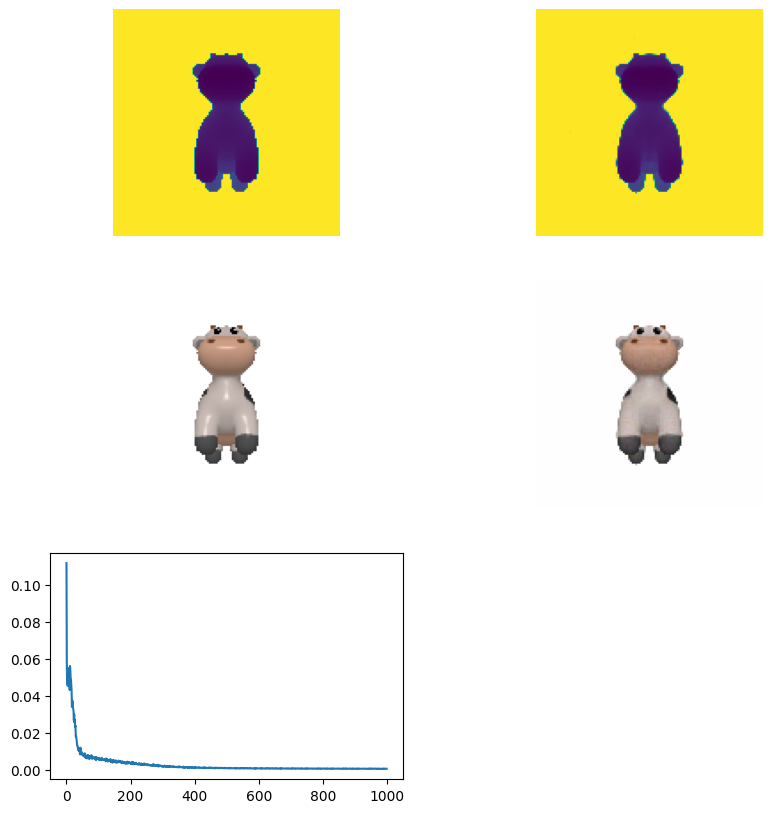

In [6]:
loss_history = []
profile = False
num_iters = 1000
loss_num_history_averaged = 50
near = 0.5
far = 4.5

fig = plt.figure()
time_start = time.time()
plt.figure(figsize = (10,10))
for iter, batch in enumerate(cycle(dataloader)):
    optimizer.zero_grad()

    images, depths, R, T = [
        batch[k].to(device) for k in ["images", "depths", "R", "T"]
    ]

    if profile:
        torch.cuda.synchronize()
        time_start_fw = time.time()

    pred_depth, mask, pred_colors = get_predicton_for_view(
        render_module,
        image_size,
        near,
        far,
        R,
        T,
        grid,
    )

    if profile:
        torch.cuda.synchronize()
        elapsed = time.time() - time_start_fw
        print(f"fw time = {elapsed:1.5f}")

    pred_depth = dataset.bg_depth * (1-mask) + pred_depth * mask
    pred_depth = pred_depth.reshape(batch_size, image_size, image_size)
    pred_colors = pred_colors.reshape(batch_size, image_size, image_size, 3)

    loss = torch.nn.functional.mse_loss(pred_colors, images)
    if profile:
        torch.cuda.synchronize()
        time_start_bw = time.time()
    loss.backward()

    if profile:
        torch.cuda.synchronize()
        elapsed = time.time() - time_start_bw
        print(f"bw time = {elapsed:1.5f}")

    optimizer.step()

    loss_history.append(loss.item())

    if iter % 100 == 0 or iter == num_iters - 1:
        loss_avg = (
            sum(loss_history[-loss_num_history_averaged:])
            / len(loss_history[-loss_num_history_averaged:])
        )
        print(
            f"{iter:10d}: loss: {loss_avg:20.5f},"
            + f" sec/it: {(time.time() - time_start) / (iter+1):1.4f}."
        )

    if iter == num_iters - 1:
        plt.subplot(3, 2, 1)
        plt.imshow(depths[0].cpu())
        plt.axis('off')
        plt.subplot(3, 2, 2)
        plt.imshow(pred_depth[0].detach().cpu().reshape(depths[0].shape))
        plt.axis('off')
        plt.subplot(3, 2, 3)
        plt.imshow(images[0].detach().cpu())
        plt.axis('off')
        plt.subplot(3, 2, 4)
        plt.imshow(pred_colors[0].detach().cpu())
        plt.axis('off')
        plt.subplot(3, 2, 5)
        plt.plot(loss_history)
    if iter == num_iters - 1:
        break


In [10]:
# Render video using a sphere camera trajectory
n_cameras = 100


sphere_R, sphere_T = get_sphere_cameras(n_cameras, elevation=30, distance=2.5)

pred_depth_s, pred_colors_s = [], []

for i in range(100):
    R_, T_ = sphere_R[i].unsqueeze(0).to(device), sphere_T[i].unsqueeze(0).to(device)

    pred_depth, mask, pred_colors = get_predicton_for_view(
        render_module,
        image_size,
        near,
        far,
        R_,
        T_,
        grid
    )
    
    pred_depth = dataset.bg_depth * (1-mask) + pred_depth * mask
    pred_depth = pred_depth.reshape(image_size, image_size)
    pred_colors = pred_colors.reshape(image_size, image_size, 3)

    pred_depth_s.append(pred_depth.detach().cpu().numpy())
    pred_colors_s.append(np.uint8(pred_colors.detach().cpu().numpy() * 255))
    
save_image_list_to_video("output.mp4", pred_colors_s)